In [1]:
import numpy as np
import h5py
import string
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
# Meta data of papers
class PaperMeta(object):
    def __init__(self, title, abstract, keyword, rating, url, withdrawn, decision):
        self.title = title  # str
        self.abstract = abstract  # str
        self.keyword = keyword  # list[str]
        self.rating = rating  # list[int]
        self.url = url
        self.withdrawn = withdrawn
        self.decision = decision
        
        if len(self.rating) > 0:
            self.average_rating = np.mean(rating)
        else:
            self.average_rating = -1

            
class Keyword(object):
    def __init__(self, keyword, frequency, rating):
        self.keyword = keyword  # list[str]
        self.frequency = frequency
        self.rating = rating  # list[int]        
    
    def average_rating(self):
        if len(self.rating) > 0:
            return np.mean(self.rating)
        else:
            return -1
    
    def update_frequency(self, frequency):
        self.frequency += frequency
        
    def update_rating(self, rating):
        self.rating = np.concatenate((self.rating, rating))
            
            
def write_meta(meta_list, filename):
    f = h5py.File(filename, 'w')
    for i, m in enumerate(meta_list):
        grp = f.create_group(str(i))
        grp['title'] = m.title
        grp['abstract'] = m.abstract
        grp['keyword'] = '#'.join(m.keyword)
        grp['rating'] = m.rating
        grp['url'] = m.url
        grp['withdrawn'] = m.withdrawn 
        grp['decision'] = m.decision
    f.close()
    
    
def read_meta(filename):
    f = h5py.File(filename, 'r')
    meta_list = []
    for k in list(f.keys()):
        meta_list.append(PaperMeta(
            f[k]['title'].value, 
            f[k]['abstract'].value, 
            f[k]['keyword'].value.split('#'),
            f[k]['rating'].value,
            f[k]['url'].value,
            f[k]['withdrawn'].value,            
            f[k]['decision'].value,                        
        ))
    return meta_list


def crawl_meta(meta_hdf5=None, write_meta_name='data.hdf5'):
    
    if meta_hdf5 is None:
        # Crawl the meta data from OpenReview
        # Set up a browser to crawl from dynamic web pages 
        from selenium import webdriver
        from selenium.webdriver.chrome.options import Options
        
        # from pyvirtualdisplay import Display
        # display = Display(visible=0, size=(800, 800))
        # display.start()
        
        import time
        # executable_path = '/usr/local/bin/chromedriver'
        executable_path = '/Users/waltersun/Desktop/chromedriver'
        options = Options()
        options.add_argument("--headless")
        browser = webdriver.Chrome(options=options, executable_path=executable_path)            
    
        # Load all URLs for all ICLR submissions
        urls = []
        with open('urls.txt') as f:
            urls = f.readlines()
        urls = [url.strip() for url in urls]
        # urls = urls[:10]
        
        meta_list = [] 
        wait_time = 0.5
        max_try = 1000
        for i, url in enumerate(urls):
            try:
                browser.get(url)
                time.sleep(wait_time)
                key = browser.find_elements_by_class_name("note_content_field")
                key = [k.text for k in key]
                withdrawn = 'Withdrawal Confirmation:' in key
                value = browser.find_elements_by_class_name("note_content_value")
                value = [v.text for v in value]

                # title
                title = string.capwords(browser.find_element_by_class_name("note_content_title").text)
                # abstract
                valid = False
                tries = 0
                while not valid:
                    if 'Abstract:' in key:
                        valid = True
                    else:
                        time.sleep(wait_time)
                        tries += 1
                        key = browser.find_elements_by_class_name("note_content_field")
                        key = [k.text for k in key]
                        withdrawn = 'Withdrawal Confirmation:' in key
                        value = browser.find_elements_by_class_name("note_content_value")
                        value = [v.text for v in value]                        
                        if tries >= max_try:
                            print('Reached max try: {} ({})'.format(title, url))
                            break
                abstract = ' '.join(value[key.index('Abstract:')].split('\n'))
                # keyword
                if 'Keywords:' in key:
                    keyword = value[key.index('Keywords:')].split(',')
                    keyword = [k.strip(' ') for k in keyword]
                    keyword = [''.join(string.capwords(k).split(' ')) for k in keyword if not k == '']
                    for j in range(len(keyword)):
                        if '-' in keyword[j]:
                            keyword[j] = ''.join([string.capwords(kk) for kk in keyword[j].split('-')])       
                else:
                    keyword = []
                # rating
                rating_idx = [i for i, x in enumerate(key) if x == "Rating:"]
                rating = []
                if len(rating_idx) > 0:
                    for idx in rating_idx:
                        rating.append(int(value[idx].split(":")[0]))
                # decision
                if 'Recommendation:' in key:
                    decision = value[key.index('Recommendation:')]
                else:
                    decision = 'N/A'
                print('[{}] [Abs: {} chars, keywords: {}, ratings: {}{}] {}{}'.format(
                    i+1, len(abstract), len(keyword), rating, 
                    '' if decision == 'N/A' else ', decision: {}'.format(decision), 
                    title, '' if not withdrawn else ' (withdrawn)'))
                meta_list.append(PaperMeta(title, abstract, keyword, rating, url, withdrawn, decision))
            except:
                print('Failed to load {}'.format(url))
            
        # Save the crawled data
        write_meta(meta_list, write_meta_name)
    else:
        # Load the meta data from local
        meta_list = read_meta(meta_hdf5)
    return meta_list

In [3]:
# Get the meta data
# Uncomment this if you want to load the previously stored data file
# meta_list = crawl_meta('data.hdf5')
# Uncomment this if you want to cral data from scratch
meta_list = crawl_meta()
num_withdrawn = len([m for m in meta_list if m.withdrawn])
print('Number of submissions: {} (withdrawn submissions: {})'.format(
    len(meta_list), num_withdrawn))

[1] [Abs: 798 chars, keywords: 3, ratings: []] Adversarial Training With Voronoi Constraints (withdrawn)
[2] [Abs: 1430 chars, keywords: 3, ratings: [3, 3, 3]] Towards Stable And Comprehensive Domain Alignment: Max-margin Domain-adversarial Training
[3] [Abs: 1118 chars, keywords: 3, ratings: [6, 3, 3]] ``"best-of-many-samples" Distribution Matching
[4] [Abs: 709 chars, keywords: 3, ratings: []] Deepobfuscode: Source Code Obfuscation Through Sequence-to-sequence Networks
[5] [Abs: 1228 chars, keywords: 1, ratings: [6, 6, 6]] Cm3: Cooperative Multi-goal Multi-stage Multi-agent Reinforcement Learning
[6] [Abs: 1283 chars, keywords: 4, ratings: [3, 8, 1]] Decoupling Weight Regularization From Batch Size For Model Compression
[7] [Abs: 414 chars, keywords: 4, ratings: [3, 1, 3]] Towards Scalable Imitation Learning For Multi-agent Systems With Graph Neural Networks
[8] [Abs: 1243 chars, keywords: 5, ratings: [3, 8, 3]] Neural Module Networks For Reasoning Over Text
[9] [Abs: 946 chars, keyw

[71] [Abs: 804 chars, keywords: 12, ratings: [8, 3, 6, 8]] Dream To Control: Learning Behaviors By Latent Imagination
[72] [Abs: 1039 chars, keywords: 4, ratings: [3, 3, 6]] Compositional Languages Emerge In A Neural Iterated Learning Model
[73] [Abs: 1178 chars, keywords: 0, ratings: [3, 1, 1]] Selective Sampling For Accelerating Training Of Deep Neural Networks
[74] [Abs: 1738 chars, keywords: 4, ratings: [1, 6, 1]] On Solving Cooperative Decentralized Marl Problems With Sparse Reinforcements
[75] [Abs: 1262 chars, keywords: 0, ratings: []] Combiner: Inductively Learning Tree Structured Attention In Transformers (withdrawn)
[76] [Abs: 1004 chars, keywords: 5, ratings: [1, 3, 1]] The Generalization-stability Tradeoff In Neural Network Pruning
[77] [Abs: 934 chars, keywords: 3, ratings: [3, 3, 3]] Elastic-infogan: Unsupervised Disentangled Representation Learning In Imbalanced Data
[78] [Abs: 759 chars, keywords: 7, ratings: [3, 3, 1]] Spectrobank: A Filter-bank Convolutional Layer For

[138] [Abs: 855 chars, keywords: 4, ratings: [6, 3, 6]] Effects Of Linguistic Labels On Learned Visual Representations In Convolutional Neural Networks: Labels Matter!
[139] [Abs: 1260 chars, keywords: 5, ratings: [3, 3, 3]] Stochastic Prototype Embeddings
[140] [Abs: 1455 chars, keywords: 3, ratings: [3, 1, 1]] Semi-supervised Boosting Via Self Labelling
[141] [Abs: 872 chars, keywords: 2, ratings: [6, 6, 6]] Sampling-free Learning Of Bayesian Quantized Neural Networks
[142] [Abs: 1457 chars, keywords: 0, ratings: [3, 6]] Sign-opt: A Query-efficient Hard-label Adversarial Attack
[143] [Abs: 1125 chars, keywords: 3, ratings: [3, 3, 3]] First-order Preconditioning Via Hypergradient Descent
[144] [Abs: 1155 chars, keywords: 6, ratings: [1, 8, 6]] Controlling Generative Models With Continuous Factors Of Variations
Failed to load https://openreview.net/forum?id=rkgAb1Btvr
[146] [Abs: 1262 chars, keywords: 5, ratings: [1, 1, 3]] Ems: End-to-end Model Search For Network Architecture, Pruning

[207] [Abs: 1264 chars, keywords: 2, ratings: [1, 3, 3]] The Convex Information Bottleneck Lagrangian
[208] [Abs: 929 chars, keywords: 4, ratings: [6, 3, 6]] Learning Entailment-based Sentence Embeddings From Natural Language Inference
[209] [Abs: 823 chars, keywords: 5, ratings: [3, 6, 3]] Learning Self-correctable Policies And Value Functions From Demonstrations With Negative Sampling
[210] [Abs: 788 chars, keywords: 2, ratings: [3, 6, 3]] Attack-resistant Federated Learning With Residual-based Reweighting
[211] [Abs: 827 chars, keywords: 3, ratings: [1, 1, 6]] Generalized Domain Adaptation With Covariate And Label Shift Co-alignment
[212] [Abs: 865 chars, keywords: 4, ratings: [3, 3, 3]] Infinite-horizon Off-policy Policy Evaluation With Multiple Behavior Policies
[213] [Abs: 1411 chars, keywords: 4, ratings: [6, 8, 6]] Emergence Of Functional And Structural Properties Of The Head Direction System By Optimization Of Recurrent Neural Networks
[214] [Abs: 381 chars, keywords: 0, ratin

[275] [Abs: 1349 chars, keywords: 5, ratings: [3, 3, 1]] Learning Dna Folding Patterns With Recurrent Neural Networks
[276] [Abs: 873 chars, keywords: 2, ratings: [6, 8, 6]] The Ingredients Of Real World Robotic Reinforcement Learning
[277] [Abs: 723 chars, keywords: 2, ratings: [1, 1, 1]] An Attention-based Deep Net For Learning To Rank
[278] [Abs: 1145 chars, keywords: 0, ratings: [3, 6, 1]] Training Deep Neural Networks With Partially Adaptive Momentum
[279] [Abs: 1088 chars, keywords: 4, ratings: [6, 6, 6]] Composition-based Multi-relational Graph Convolutional Networks
[280] [Abs: 1078 chars, keywords: 4, ratings: [6, 3, 6]] Gradient Perturbation Is Underrated For Differentially Private Convex Optimization
[281] [Abs: 1157 chars, keywords: 3, ratings: [6, 3, 6]] Efficient Riemannian Optimization On The Stiefel Manifold Via The Cayley Transform
[282] [Abs: 1012 chars, keywords: 3, ratings: [6, 3, 3]] Task Level Data Augmentation For Meta-learning
[283] [Abs: 1027 chars, keywords: 3

[342] [Abs: 779 chars, keywords: 3, ratings: [3, 3, 3]] Wasserstein Robust Reinforcement Learning
[343] [Abs: 1081 chars, keywords: 2, ratings: [6, 1, 1]] Deep Multivariate Mixture Of Gaussians For Object Detection Under Occlusion
[344] [Abs: 1330 chars, keywords: 4, ratings: [3, 3, 1]] Adversarial Neural Pruning
[345] [Abs: 1537 chars, keywords: 6, ratings: [6, 6]] Neural Communication Systems With Bandwidth-limited Channel
[346] [Abs: 1343 chars, keywords: 4, ratings: [1, 3, 8]] Federated User Representation Learning
[347] [Abs: 1243 chars, keywords: 3, ratings: [6, 8]] Sliced Cramer Synaptic Consolidation For Preserving Deeply Learned Representations
[348] [Abs: 768 chars, keywords: 4, ratings: [8, 6, 3]] Robust Training With Ensemble Consensus
[349] [Abs: 1305 chars, keywords: 3, ratings: [1, 3, 3]] Learning Out-of-distribution Detection Without Out-of-distribution Data
[350] [Abs: 952 chars, keywords: 0, ratings: [3, 6, 3, 8]] Crafting Data-free Universal Adversaries With Dilate L

[413] [Abs: 966 chars, keywords: 2, ratings: [3, 8, 3]] Visual Explanation For Deep Metric Learning
[414] [Abs: 723 chars, keywords: 4, ratings: [6, 6, 6]] Locality And Compositionality In Zero-shot Learning
[415] [Abs: 1224 chars, keywords: 6, ratings: [3, 1, 6, 1]] Wide Neural Networks Are Interpolating Kernel Methods: Impact Of Initialization On Generalization
[416] [Abs: 751 chars, keywords: 5, ratings: [6, 3, 3]] Zeno++: Robust Fully Asynchronous Sgd
[417] [Abs: 1174 chars, keywords: 5, ratings: [3, 3]] Analyzing The Role Of Model Uncertainty For Electronic Health Records
[418] [Abs: 1091 chars, keywords: 9, ratings: [6, 6, 6]] Analysis Of Video Feature Learning In Two-stream Cnns On The Example Of Zebrafish Swim Bout Classification
[419] [Abs: 1096 chars, keywords: 2, ratings: [3, 6, 3]] Adasample: Adaptive Sampling Of Hard Positives For Descriptor Learning
[420] [Abs: 853 chars, keywords: 3, ratings: [8, 6, 6]] Distributed Bandit Learning: Near-optimal Regret With Efficient Comm

[482] [Abs: 1072 chars, keywords: 5, ratings: [3, 1, 6]] Improved Generalization Bound Of Permutation Invariant Deep Neural Networks
[483] [Abs: 960 chars, keywords: 3, ratings: [3, 3, 3]] Pruning Depthwise Separable Convolutions For Extra Efficiency Gain Of Lightweight Models
[484] [Abs: 1022 chars, keywords: 5, ratings: [1, 3]] Towards Unifying Neural Architecture Space Exploration And Generalization
[485] [Abs: 495 chars, keywords: 2, ratings: [8, 6, 8, 6]] Vq-wav2vec: Self-supervised Learning Of Discrete Speech Representations
[486] [Abs: 1513 chars, keywords: 4, ratings: [1, 1, 3]] Leveraging Adversarial Examples To Obtain Robust Second-order Representations
[487] [Abs: 1314 chars, keywords: 5, ratings: [3, 6, 6]] The Early Phase Of Neural Network Training
[488] [Abs: 1153 chars, keywords: 2, ratings: [8, 3, 3]] Extreme Classification Via Adversarial Softmax Approximation
[489] [Abs: 952 chars, keywords: 4, ratings: [3, 6, 1]] Contextual Inverse Reinforcement Learning
[490] [Abs: 

[549] [Abs: 1751 chars, keywords: 7, ratings: [3, 6, 3]] Fast Sparse Convnets
[550] [Abs: 836 chars, keywords: 2, ratings: [3, 6, 6]] Atomnas: Fine-grained End-to-end Neural Architecture Search
[551] [Abs: 1221 chars, keywords: 3, ratings: [6, 3, 3]] Semantic Hierarchy Emerges In The Deep Generative Representations For Scene Synthesis
[552] [Abs: 1195 chars, keywords: 4, ratings: [3, 6, 3]] Dataset Distillation
[553] [Abs: 1145 chars, keywords: 3, ratings: [6, 8, 6, 6, 1]] Statistically Consistent Saliency Estimation
[554] [Abs: 1067 chars, keywords: 3, ratings: [3, 3, 6]] Deep Variational Semi-supervised Novelty Detection
[555] [Abs: 1848 chars, keywords: 3, ratings: [6, 3, 3]] Learning To Discretize: Solving 1d Scalar Conservation Laws Via Deep Reinforcement Learning
[556] [Abs: 843 chars, keywords: 2, ratings: [3, 6, 3]] Learning Surrogate Losses
[557] [Abs: 1523 chars, keywords: 2, ratings: [6, 3]] Energy-aware Neural Architecture Optimization With Fast Splitting Steepest Descent
[

[616] [Abs: 1098 chars, keywords: 2, ratings: [1, 3, 6]] Model Inversion Networks For Model-based Optimization
[617] [Abs: 1347 chars, keywords: 5, ratings: [3, 8, 3]] Feature Map Transform Coding For Energy-efficient Cnn Inference
[618] [Abs: 790 chars, keywords: 4, ratings: [3, 3, 3]] The Differentiable Cross-entropy Method
[619] [Abs: 877 chars, keywords: 3, ratings: [3, 3, 6]] Fair Resource Allocation In Federated Learning
[620] [Abs: 1101 chars, keywords: 4, ratings: [3, 1]] Modir: Multi-objective Dimensionality Reduction For Joint Data Visualisation
[621] [Abs: 1031 chars, keywords: 3, ratings: [1, 3, 3]] Namsg: An Efficient Method For Training Neural Networks
[622] [Abs: 783 chars, keywords: 2, ratings: [1, 1]] Improving Differentially Private Models With Active Learning
[623] [Abs: 1626 chars, keywords: 5, ratings: [3, 8, 8]] Decentralized Distributed Ppo: Mastering Pointgoal Navigation
[624] [Abs: 1170 chars, keywords: 5, ratings: [3, 6, 1]] Pdp: A General Neural Framework For

[682] [Abs: 746 chars, keywords: 4, ratings: [8, 8, 6]] Rna Secondary Structure Prediction By Learning Unrolled Algorithms
[683] [Abs: 815 chars, keywords: 3, ratings: [6, 3, 1]] Better Knowledge Retention Through Metric Learning
[684] [Abs: 818 chars, keywords: 2, ratings: [3, 3, 3]] Convergence Analysis Of A Momentum Algorithm With Adaptive Step Size For Nonconvex Optimization
[685] [Abs: 777 chars, keywords: 3, ratings: [3, 1, 1]] Neuralucb: Contextual Bandits With Neural Network-based Exploration
[686] [Abs: 810 chars, keywords: 0, ratings: [3, 3, 3]] A Gradient-based Approach To Neural Networks Structure Learning
[687] [Abs: 965 chars, keywords: 5, ratings: [6, 3]] Neural Maximum Common Subgraph Detection With Guided Subgraph Extraction
[688] [Abs: 1018 chars, keywords: 2, ratings: [3, 1, 3]] Lossless Data Compression With Transformer
[689] [Abs: 937 chars, keywords: 2, ratings: [6, 6, 1]] Neural Markov Logic Networks
[690] [Abs: 1106 chars, keywords: 3, ratings: [1, 6, 3]] Deep S

[750] [Abs: 1048 chars, keywords: 1, ratings: [6, 3, 1]] Learning From Positive And Unlabeled Data With Adversarial Training
[751] [Abs: 958 chars, keywords: 2, ratings: [6, 3, 3]] Walking On The Edge: Fast, Low-distortion Adversarial Examples
[752] [Abs: 1008 chars, keywords: 3, ratings: [6, 1, 6]] Overlearning Reveals Sensitive Attributes
[753] [Abs: 839 chars, keywords: 2, ratings: [1, 8, 1]] Learn Interpretable Word Embeddings Efficiently With Von Mises-fisher Distribution
[754] [Abs: 854 chars, keywords: 6, ratings: [6, 3, 6]] The Shape Of Data: Intrinsic Distance For Data Distributions
[755] [Abs: 977 chars, keywords: 0, ratings: [3, 6, 6]] Locally Constant Networks
[756] [Abs: 1520 chars, keywords: 4, ratings: [3, 1, 3]] Mixture Density Networks Find Viewpoint The Dominant Factor For Accurate Spatial Offset Regression
[757] [Abs: 1287 chars, keywords: 0, ratings: [6, 1, 6]] Domain-invariant Learning Using Adaptive Filter Decomposition
[758] [Abs: 1563 chars, keywords: 2, ratings

[817] [Abs: 990 chars, keywords: 0, ratings: [1, 6, 1]] Extractor-attention Network: A New Attention Network With Hybrid Encoders For Chinese Text Classification
[818] [Abs: 1176 chars, keywords: 4, ratings: [1, 1, 1]] Improved Image Augmentation For Convolutional Neural Networks By Copyout And Copypairing
[819] [Abs: 1551 chars, keywords: 4, ratings: [3, 3, 3]] Efficient Exploration Via State Marginal Matching
[820] [Abs: 1398 chars, keywords: 2, ratings: [6, 6, 3]] Towards Better Understanding Of Adaptive Gradient Algorithms In Generative Adversarial Nets
[821] [Abs: 936 chars, keywords: 4, ratings: [6, 6]] Logan: Latent Optimisation For Generative Adversarial Networks
[822] [Abs: 736 chars, keywords: 4, ratings: [6, 3, 3]] A Simple Approach To The Noisy Label Problem Through The Gambler's Loss
[823] [Abs: 1212 chars, keywords: 3, ratings: [6, 3, 3]] Regularization Matters In Policy Optimization
[824] [Abs: 1663 chars, keywords: 5, ratings: [8, 8]] Depth-width Trade-offs For Relu Net

[884] [Abs: 901 chars, keywords: 7, ratings: [3, 3, 1]] How Many Weights Are Enough : Can Tensor Factorization Learn Efficient Policies ?
[885] [Abs: 728 chars, keywords: 3, ratings: [1, 1, 1]] Vusfa:variational Universal Successor Features Approximator
[886] [Abs: 1177 chars, keywords: 4, ratings: [1, 1, 3]] Quantum Optical Experiments Modeled By Long Short-term Memory
[887] [Abs: 1040 chars, keywords: 2, ratings: [3, 3, 1]] Buzz: Buffer Zones For Defending Adversarial Examples In Image Classification
[888] [Abs: 1072 chars, keywords: 3, ratings: [3, 6]] Rl-lim: Reinforcement Learning-based Locally Interpretable Modeling
[889] [Abs: 1131 chars, keywords: 4, ratings: [3, 3, 3]] Slow Thinking Enables Task-uncertain Lifelong And Sequential Few-shot Learning
[890] [Abs: 1061 chars, keywords: 3, ratings: [6, 8, 3]] Improving Multi-manifold Gans With A Learned Noise Prior
[891] [Abs: 1259 chars, keywords: 8, ratings: [3, 3, 6]] Compressing Bert: Studying The Effects Of Weight Pruning On Tra

[950] [Abs: 1664 chars, keywords: 2, ratings: [3, 1, 1]] Pixel Co-occurence Based Loss Metrics For Super Resolution Texture Recovery
[951] [Abs: 1001 chars, keywords: 3, ratings: [6, 6, 6]] Compression Based Bound For Non-compressed Network: Unified Generalization Error Analysis Of Large Compressible Deep Neural Network
[952] [Abs: 931 chars, keywords: 4, ratings: [8, 6, 6]] Learning To Plan In High Dimensions Via Neural Exploration-exploitation Trees
[953] [Abs: 916 chars, keywords: 11, ratings: [1, 3]] Algonet: Smooth Algorithmic Neural Networks
[954] [Abs: 1006 chars, keywords: 3, ratings: [3, 1, 3]] Improving The Generalization Of Visual Navigation Policies Using Invariance Regularization
[955] [Abs: 1178 chars, keywords: 3, ratings: [3, 6, 8]] Discovering Motor Programs By Recomposing Demonstrations
[956] [Abs: 1099 chars, keywords: 5, ratings: [3, 1, 3]] Network Pruning For Low-rank Binary Index
[957] [Abs: 1410 chars, keywords: 0, ratings: [8, 6, 3]] A Deep Recurrent Neural Netw

[1018] [Abs: 769 chars, keywords: 4, ratings: [6, 6]] Quantifying The Cost Of Reliable Photo Authentication Via High-performance Learned Lossy Representations
[1019] [Abs: 1298 chars, keywords: 5, ratings: [8, 6, 6]] Disentanglement Through Nonlinear Ica With General Incompressible-flow Networks (gin)
[1020] [Abs: 1387 chars, keywords: 6, ratings: [8, 3, 6]] Fooling Detection Alone Is Not Enough: Adversarial Attack Against Multiple Object Tracking
[1021] [Abs: 1216 chars, keywords: 4, ratings: [6, 6, 6]] Defensive Tensorization: Randomized Tensor Parametrization For Robust Neural Networks
[1022] [Abs: 1354 chars, keywords: 6, ratings: [3, 3]] On Weight-sharing And Bilevel Optimization In Architecture Search
[1023] [Abs: 849 chars, keywords: 4, ratings: [1, 1]] Pretraining Boosts Out-of-domain Robustness For Pose Estimation
[1024] [Abs: 1302 chars, keywords: 2, ratings: [3, 3, 3]] Adversarially Robust Generalization Just Requires More Unlabeled Data
[1025] [Abs: 1017 chars, keywords: 3,

[1084] [Abs: 859 chars, keywords: 3, ratings: [1, 3, 3]] Is There Mode Collapse? A Case Study On Face Generation And Its Black-box Calibration
[1085] [Abs: 1022 chars, keywords: 4, ratings: [6, 3, 3, 1]] Defense Against Adversarial Examples By Encoder-assisted Search In The Latent Coding Space
[1086] [Abs: 961 chars, keywords: 3, ratings: [3, 1, 3]] Few-shot Text Classification With Distributional Signatures
[1087] [Abs: 767 chars, keywords: 3, ratings: [1, 3, 1]] Learning Good Policies By Learning Good Perceptual Models
[1088] [Abs: 972 chars, keywords: 3, ratings: [6, 6, 3]] Generalized Clustering By Learning To Optimize Expected Normalized Cuts
[1089] [Abs: 612 chars, keywords: 5, ratings: [3, 3, 3]] Classification Attention For Chinese Ner
[1090] [Abs: 1351 chars, keywords: 4, ratings: [6, 3, 6]] A Learning-based Iterative Method For Solving Vehicle Routing Problems
[1091] [Abs: 796 chars, keywords: 5, ratings: [1, 3, 6]] Improved Structural Discovery And Representation Learning Of

[1149] [Abs: 1261 chars, keywords: 3, ratings: [6, 3, 3]] Multigrid Neural Memory
[1150] [Abs: 1460 chars, keywords: 4, ratings: [3, 3, 1]] Global Reasoning Network For Image Super-resolution
[1151] [Abs: 1007 chars, keywords: 5, ratings: [3, 3, 6]] On The Expected Running Time Of Nonconvex Optimization With Early Stopping
[1152] [Abs: 1481 chars, keywords: 0, ratings: [3, 3, 3]] Yaogan: Learning Worst-case Competitive Algorithms From Self-generated Inputs
[1153] [Abs: 1243 chars, keywords: 3, ratings: [6, 3, 6]] Generalized Natural Language Grounded Navigation Via Environment-agnostic Multitask Learning
[1154] [Abs: 1506 chars, keywords: 4, ratings: [3, 6, 6]] A Generalized Training Approach For Multiagent Learning
[1155] [Abs: 1238 chars, keywords: 6, ratings: [6, 3, 3]] Improving Confident-classifiers For Out-of-distribution Detection
[1156] [Abs: 988 chars, keywords: 8, ratings: [6, 8, 6]] On Identifiability In Transformers
[1157] [Abs: 1198 chars, keywords: 5, ratings: [6, 8, 3, 3

[1216] [Abs: 1327 chars, keywords: 6, ratings: [6, 8, 8]] Directional Message Passing For Molecular Graphs
[1217] [Abs: 1258 chars, keywords: 2, ratings: [3, 3, 1]] Probabilistic View Of Multi-agent Reinforcement Learning: A Unified Approach
[1218] [Abs: 1550 chars, keywords: 4, ratings: [6, 3, 8]] On Variational Learning Of Controllable Representations For Text Without Supervision
[1219] [Abs: 1366 chars, keywords: 4, ratings: [6, 6, 3, 3]] Meta-learning Deep Energy-based Memory Models
[1220] [Abs: 1361 chars, keywords: 2, ratings: [3, 6, 1]] Gan: A Few-shot Learning Approach With Diverse And Discriminative Feature Synthesis
[1221] [Abs: 1614 chars, keywords: 3, ratings: [6, 8, 3]] Autoq: Automated Kernel-wise Neural Network Quantization
[1222] [Abs: 1033 chars, keywords: 7, ratings: [3, 3, 6, 3]] Data-efficient Image Recognition With Contrastive Predictive Coding
[1223] [Abs: 1347 chars, keywords: 3, ratings: [3, 6, 1]] Optimizing Loss Landscape Connectivity Via Neuron Alignment
[122

[1283] [Abs: 1318 chars, keywords: 2, ratings: [3, 1, 1]] Towards Disentangling Non-robust And Robust Components In Performance Metric
[1284] [Abs: 1597 chars, keywords: 2, ratings: [3, 8, 3]] Projected Canonical Decomposition For Knowledge Base Completion
[1285] [Abs: 1672 chars, keywords: 3, ratings: [6, 3]] Prototype-assisted Adversarial Learning For Unsupervised Domain Adaptation
[1286] [Abs: 1273 chars, keywords: 0, ratings: [3, 6, 3]] Adversarial Privacy Preservation Under Attribute Inference Attack
[1287] [Abs: 1188 chars, keywords: 4, ratings: [6, 8, 8, 3]] Improved Sample Complexities For Deep Neural Networks And Robust Classification Via An All-layer Margin
[1288] [Abs: 928 chars, keywords: 3, ratings: [6, 6, 3]] Ted: A Pretrained Unsupervised Summarization Model With Theme Modeling And Denoising
[1289] [Abs: 365 chars, keywords: 2, ratings: [1, 3]] Learning To Optimize Via Dual Space Preconditioning
[1290] [Abs: 1534 chars, keywords: 0, ratings: [6, 6, 8]] Rényi Fair Inferen

[1349] [Abs: 1629 chars, keywords: 3, ratings: [6, 6, 3]] Goal-conditioned Video Prediction
[1350] [Abs: 1282 chars, keywords: 4, ratings: [3, 3, 3]] Style-based Encoder Pre-training For Multi-modal Image Synthesis
[1351] [Abs: 1299 chars, keywords: 2, ratings: [6, 8, 6]] Decoupling Representation And Classifier For Long-tailed Recognition
[1352] [Abs: 1020 chars, keywords: 2, ratings: [6, 6, 6]] Projection Based Constrained Policy Optimization
[1353] [Abs: 853 chars, keywords: 3, ratings: [8, 3, 3]] Rpgan: Random Paths As A Latent Space For Gan Interpretability
[1354] [Abs: 1962 chars, keywords: 5, ratings: [8, 8, 1]] Nas Evaluation Is Frustratingly Hard
[1355] [Abs: 892 chars, keywords: 2, ratings: [1, 1, 1]] Discriminator Based Corpus Generation For General Code Synthesis
[1356] [Abs: 1299 chars, keywords: 0, ratings: [8, 8, 8]] Backpack: Packing More Into Backprop
[1357] [Abs: 906 chars, keywords: 2, ratings: [6, 8]] Collaborative Inter-agent Knowledge Distillation For Reinforcemen

[1417] [Abs: 959 chars, keywords: 0, ratings: [6, 3, 3]] Mist: Multiple Instance Spatial Transformer Networks
[1418] [Abs: 1604 chars, keywords: 6, ratings: [3, 8, 6]] Denoising And Regularization Via Exploiting The Structural Bias Of Convolutional Generators
[1419] [Abs: 809 chars, keywords: 3, ratings: [1, 3, 1]] Benchmarking Adversarial Robustness
[1420] [Abs: 866 chars, keywords: 0, ratings: [1, 6, 1]] Unsupervised Out-of-distribution Detection With Batch Normalization
[1421] [Abs: 1318 chars, keywords: 2, ratings: [6, 8]] Memo: A Deep Network For Flexible Combination Of Episodic Memories
[1422] [Abs: 1224 chars, keywords: 3, ratings: [3, 6, 3]] Walking The Tightrope: An Investigation Of The Convolutional Autoencoder Bottleneck
[1423] [Abs: 1549 chars, keywords: 0, ratings: [3, 6, 3]] Asymptotic Learning Curves Of Kernel Methods: Empirical Data V.s. Teacher-student Paradigm
[1424] [Abs: 595 chars, keywords: 3, ratings: [3, 1, 6]] Stochastic Weight Averaging In Parallel: Large-batch

[1483] [Abs: 839 chars, keywords: 3, ratings: [8, 3, 3]] Visual Hide And Seek
[1484] [Abs: 856 chars, keywords: 1, ratings: [3, 1, 1]] Techkg: A Large-scale Chinese Technology-oriented Knowledge Graph
[1485] [Abs: 764 chars, keywords: 0, ratings: [3, 3, 3]] Optimistic Adaptive Acceleration For Optimization
[1486] [Abs: 1186 chars, keywords: 9, ratings: [3, 3, 3]] Gap-aware Mitigation Of Gradient Staleness
[1487] [Abs: 905 chars, keywords: 6, ratings: [3, 3, 3]] Spectra: Sparse Entity-centric Transitions
[1488] [Abs: 1059 chars, keywords: 7, ratings: [6, 6, 3]] Quaternion Equivariant Capsule Networks For 3d Point Clouds
[1489] [Abs: 855 chars, keywords: 2, ratings: [1, 3, 1, 1]] Learning By Shaking: Computing Policy Gradients By Physical Forward-propagation
[1490] [Abs: 1676 chars, keywords: 2, ratings: []] A Deep Dive Into Count-min Sketch For Extreme Classification In Logarithmic Memory (withdrawn)
[1491] [Abs: 975 chars, keywords: 2, ratings: [3, 6, 3]] A Simple And Scalable Shape Re

[1549] [Abs: 852 chars, keywords: 4, ratings: [8, 3, 6]] Deep Network Classification By Scattering And Homotopy Dictionary Learning
[1550] [Abs: 1027 chars, keywords: 4, ratings: [3, 1, 3]] A Mechanism Of Implicit Regularization In Deep Learning
[1551] [Abs: 1741 chars, keywords: 4, ratings: [3, 3, 8]] Unknown-aware Deep Neural Network
[1552] [Abs: 1766 chars, keywords: 5, ratings: [6, 3, 8]] Meta-learning Without Memorization
[1553] [Abs: 1494 chars, keywords: 6, ratings: [6, 1]] Cover Filtration And Stable Paths In The Mapper
[1554] [Abs: 920 chars, keywords: 2, ratings: [3, 3, 3]] Improving Visual Relation Detection Using Depth Maps
[1555] [Abs: 1511 chars, keywords: 4, ratings: [3, 3]] Deep Rl For Blood Glucose Control: Lessons, Challenges, And Opportunities
[1556] [Abs: 1084 chars, keywords: 4, ratings: [6, 6, 8]] Learned Step Size Quantization
[1557] [Abs: 1304 chars, keywords: 4, ratings: [3, 8, 6]] Self: Learning To Filter Noisy Labels With Self-ensembling
[1558] [Abs: 1192 cha

[1618] [Abs: 1132 chars, keywords: 3, ratings: [3, 3, 6]] Feature Partitioning For Efficient Multi-task Architectures
[1619] [Abs: 778 chars, keywords: 2, ratings: [3, 6, 3]] Depth Creates No More Spurious Local Minima In Linear Networks
[1620] [Abs: 1139 chars, keywords: 3, ratings: [6, 1]] Continuous Control With Contexts, Provably
[1621] [Abs: 1307 chars, keywords: 3, ratings: [3, 1, 6]] Towards Understanding The Regularization Of Adversarial Robustness On Neural Networks
[1622] [Abs: 1121 chars, keywords: 4, ratings: [1, 3, 3]] On Summarized Validation Curves And Generalization
[1623] [Abs: 1343 chars, keywords: 5, ratings: [3, 3, 3]] Towards Trustworthy Predictions From Deep Neural Networks With Fast Adversarial Calibration
[1624] [Abs: 825 chars, keywords: 3, ratings: [3, 6, 6]] Captaingan: Navigate Through Embedding Space For Better Text Generation
[1625] [Abs: 1574 chars, keywords: 3, ratings: [1, 3]] Learning Low-rank Deep Neural Networks Via Singular Vector Orthogonality Regu

[1685] [Abs: 1258 chars, keywords: 3, ratings: [1, 6, 3]] Ova-inn: Continual Learning With Invertible Neural Networks
[1686] [Abs: 1048 chars, keywords: 6, ratings: [3, 1, 3]] Emergence Of Collective Policies Inside Simulations With Biased Representations
[1687] [Abs: 889 chars, keywords: 5, ratings: [3, 6]] Sparse Weight Activation Training
[1688] [Abs: 635 chars, keywords: 3, ratings: [8, 3]] Adversarial Training Generalizes Data-dependent Spectral Norm Regularization
[1689] [Abs: 801 chars, keywords: 3, ratings: [6, 6, 1]] Augmenting Self-attention With Persistent Memory
[1690] [Abs: 580 chars, keywords: 1, ratings: [3, 6]] Pnat: Non-autoregressive Transformer By Position Learning
[1691] [Abs: 830 chars, keywords: 5, ratings: [3, 3]] All Simulations Are Not Equal: Simulation Reweighing For Imperfect Information Games
[1692] [Abs: 1115 chars, keywords: 2, ratings: [3, 3, 6]] Mix & Match: Training Convnets With Mixed Image Sizes For Improved Accuracy, Speed And Scale Resiliency
[1693]

[1752] [Abs: 698 chars, keywords: 3, ratings: [8, 3, 8]] Deep Batch Active Learning By Diverse, Uncertain Gradient Lower Bounds
[1753] [Abs: 1646 chars, keywords: 3, ratings: [6, 6, 3]] Adversarial Autoaugment
[1754] [Abs: 1134 chars, keywords: 3, ratings: [6, 6, 6]] Deep Imitative Models For Flexible Inference, Planning, And Control
[1755] [Abs: 1111 chars, keywords: 0, ratings: [3, 3, 8]] Statistical Adaptive Stochastic Optimization
[1756] [Abs: 860 chars, keywords: 3, ratings: [6, 6, 6]] Dynamic Model Pruning With Feedback
[1757] [Abs: 1081 chars, keywords: 4, ratings: [3, 1, 3]] Unsupervised Universal Self-attention Network For Graph Classification
[1758] [Abs: 564 chars, keywords: 4, ratings: [3, 1, 1]] Two-step Uncertainty Network For Taskdriven Sensor Placement
[1759] [Abs: 1486 chars, keywords: 5, ratings: [3, 6, 6]] Noisy Machines: Understanding Noisy Neural Networks And Enhancing Robustness To Analog Hardware Errors Using Distillation
[1760] [Abs: 1489 chars, keywords: 3, rat

[1820] [Abs: 795 chars, keywords: 3, ratings: [3, 3, 3]] Language-independent Cross-lingual Contextual Representations
[1821] [Abs: 1357 chars, keywords: 2, ratings: [8, 6, 6]] Mathematical Reasoning In Latent Space
[1822] [Abs: 874 chars, keywords: 4, ratings: [3, 6, 3]] Robust Few-shot Learning With Adversarially Queried Meta-learners
[1823] [Abs: 885 chars, keywords: 0, ratings: [6, 6, 3]] Graph Convolutional Reinforcement Learning
[1824] [Abs: 724 chars, keywords: 2, ratings: [3, 8, 1]] State Alignment-based Imitation Learning
[1825] [Abs: 1080 chars, keywords: 4, ratings: [1, 1, 6]] Uncertainty - Sensitive Learning And Planning With Ensembles
[1826] [Abs: 944 chars, keywords: 4, ratings: [3, 3, 3]] Domain Adaptation Through Label Propagation: Learning Clustered And Aligned Features
[1827] [Abs: 1044 chars, keywords: 3, ratings: [3, 3, 1]] Improving Semantic Parsing With Neural Generator-reranker Architecture
[1828] [Abs: 1200 chars, keywords: 1, ratings: [3, 8, 3]] Continual Learn

[1888] [Abs: 990 chars, keywords: 0, ratings: [3, 1, 1]] Learning Rnns With Commutative State Transitions
[1889] [Abs: 1210 chars, keywords: 3, ratings: [3, 3, 1]] Overcoming Catastrophic Forgetting Via Hessian-free Curvature Estimates
[1890] [Abs: 1582 chars, keywords: 4, ratings: [6, 6, 6]] Economy Statistical Recurrent Units For Inferring Nonlinear Granger Causality
[1891] [Abs: 1682 chars, keywords: 3, ratings: [3, 6, 6]] Information Geometry Of Orthogonal Initializations And Training
[1892] [Abs: 804 chars, keywords: 5, ratings: [3, 3, 1]] Continual Learning With Gated Incremental Memories For Sequential Data Processing
[1893] [Abs: 1060 chars, keywords: 0, ratings: [6, 3, 6]] Unsupervised Learning Of Efficient And Robust Speech Representations
[1894] [Abs: 968 chars, keywords: 3, ratings: [1, 6, 3]] Semantics Preserving Adversarial Attacks
[1895] [Abs: 736 chars, keywords: 5, ratings: [3, 3, 6]] Limitations For Learning From Point Clouds
[1896] [Abs: 1579 chars, keywords: 4, rati

[1956] [Abs: 1273 chars, keywords: 4, ratings: [3, 3]] Contribution Of Internal Reflection In Language Emergence With An Under-restricted Situation
[1957] [Abs: 1070 chars, keywords: 0, ratings: [3, 3, 3]] Robust Reinforcement Learning With Wasserstein Constraint
[1958] [Abs: 1131 chars, keywords: 2, ratings: [3, 6, 6]] Query-efficient Meta Attack To Deep Neural Networks
[1959] [Abs: 1340 chars, keywords: 3, ratings: [3, 1, 1]] Unsupervised Few-shot Object Recognition By Integrating Adversarial, Self-supervision, And Deep Metric Learning Of Latent Parts
[1960] [Abs: 1071 chars, keywords: 0, ratings: [3, 3, 3]] Dynamic Graph Message Passing Networks
[1961] [Abs: 1115 chars, keywords: 4, ratings: [6, 3, 1]] A⋆mcts: Search With Theoretical Guarantee Using Policy And Value Functions
[1962] [Abs: 1292 chars, keywords: 6, ratings: [3, 1, 6]] Amused: A Multi-stream Vector Representation Method For Use In Natural Dialogue
[1963] [Abs: 925 chars, keywords: 0, ratings: [1, 6, 6]] Deep Probabilis

[2023] [Abs: 903 chars, keywords: 5, ratings: [3, 3, 3]] A Coordinate-free Construction Of Scalable Natural Gradient
[2024] [Abs: 1079 chars, keywords: 5, ratings: [6, 3, 3]] Betanas: Balanced Training And Selective Drop For Neural Architecture Search
[2025] [Abs: 1041 chars, keywords: 4, ratings: [3, 6, 3]] Dynamic Scale Inference By Entropy Minimization
[2026] [Abs: 1699 chars, keywords: 0, ratings: [3, 3, 6]] Resizable Neural Networks
[2027] [Abs: 1165 chars, keywords: 0, ratings: [8, 1, 3]] Scalable Differentially Private Data Generation Via Private Aggregation Of Teacher Ensembles
[2028] [Abs: 946 chars, keywords: 3, ratings: [6, 1, 8]] Unsupervised Model Selection For Variational Disentangled Representation Learning
[2029] [Abs: 842 chars, keywords: 3, ratings: [6, 8, 3]] Unsupervised Progressive Learning And The Stam Architecture
[2030] [Abs: 1117 chars, keywords: 3, ratings: [3, 3, 6]] Why Does Hierarchy (sometimes) Work So Well In Reinforcement Learning?
[2031] [Abs: 824 chars

[2091] [Abs: 1281 chars, keywords: 3, ratings: [6, 6]] Multiplicative Interactions And Where To Find Them
[2092] [Abs: 1452 chars, keywords: 0, ratings: [6, 3, 3]] Accelerating Monte Carlo Bayesian Inference Via Approximating Predictive Uncertainty Over The Simplex
[2093] [Abs: 1192 chars, keywords: 2, ratings: [6, 6, 6]] Cophy: Counterfactual Learning Of Physical Dynamics
[2094] [Abs: 1524 chars, keywords: 3, ratings: [3, 6]] Leveraging Inductive Bias Of Neural Networks For Learning Without Explicit Human Annotations
[2095] [Abs: 1478 chars, keywords: 0, ratings: [6, 3, 6]] Learning From Imperfect Annotations: An End-to-end Approach
[2096] [Abs: 1164 chars, keywords: 10, ratings: [3, 1, 3]] On The Evaluation Of Conditional Gans
[2097] [Abs: 1141 chars, keywords: 5, ratings: [6, 3, 6, 1]] Multiagent Reinforcement Learning In Games With An Iterated Dominance Solution
[2098] [Abs: 857 chars, keywords: 10, ratings: [1, 1, 1]] White Box Network: Obtaining A Right Composition Ordering Of Fu

[2159] [Abs: 1355 chars, keywords: 2, ratings: [6, 3]] Constant Time Graph Neural Networks
[2160] [Abs: 637 chars, keywords: 3, ratings: [6, 6, 6]] Learning Video Representations Using Contrastive Bidirectional Transformer
[2161] [Abs: 1662 chars, keywords: 5, ratings: [3, 3, 1]] Semi-supervised 3d Face Reconstruction With Nonlinear Disentangled Representations
[2162] [Abs: 1186 chars, keywords: 7, ratings: [6, 3, 3]] Generative Models For Effective Ml On Private, Decentralized Datasets
[2163] [Abs: 845 chars, keywords: 4, ratings: [3, 3, 3]] Graph Residual Flow For Molecular Graph Generation
[2164] [Abs: 575 chars, keywords: 4, ratings: [3, 1, 3]] Twin Graph Convolutional Networks: Gcn With Dual Graph Support For Semi-supervised Learning
[2165] [Abs: 1129 chars, keywords: 4, ratings: [1, 6, 3]] Partial Simulation For Imitation Learning
[2166] [Abs: 1019 chars, keywords: 3, ratings: [1, 1, 1]] Incorporating Perceptual Prior To Improve Model's Adversarial Robustness
[2167] [Abs: 1164 ch

[2224] [Abs: 1159 chars, keywords: 4, ratings: [3, 3, 6]] 3d-sic: 3d Semantic Instance Completion For Rgb-d Scans
[2225] [Abs: 1713 chars, keywords: 3, ratings: [1, 1, 1]] Corpus Based Amharic Sentiment Lexicon Generation
[2226] [Abs: 1120 chars, keywords: 7, ratings: [3, 3, 3]] The Frechet Distance Of Training And Test Distribution Predicts The Generalization Gap
[2227] [Abs: 1484 chars, keywords: 11, ratings: [8, 3, 3]] Are There Any 'object Detectors' In The Hidden Layers Of Cnns Trained To Identify Objects Or Scenes?
[2228] [Abs: 1870 chars, keywords: 5, ratings: [6, 1, 1]] Flexible And Efficient Long-range Planning Through Curious Exploration
[2229] [Abs: 1319 chars, keywords: 2, ratings: [3, 3, 3]] Implicit Λ-jeffreys Autoencoders: Taking The Best Of Both Worlds
[2230] [Abs: 1327 chars, keywords: 4, ratings: [6, 3, 6]] Learning To Recognize The Unseen Visual Predicates
[2231] [Abs: 994 chars, keywords: 8, ratings: [6, 6]] The Break-even Point On The Optimization Trajectories Of D

[2293] [Abs: 1359 chars, keywords: 3, ratings: [3, 3, 3]] Robust Generative Adversarial Network
[2294] [Abs: 1286 chars, keywords: 3, ratings: [8, 6, 6]] Discriminative Particle Filter Reinforcement Learning For Complex Partial Observations
[2295] [Abs: 1442 chars, keywords: 3, ratings: [3, 3, 3]] Testing Robustness Against Unforeseen Adversaries
[2296] [Abs: 1205 chars, keywords: 4, ratings: [3, 6]] Unsupervised Representation Learning By Predicting Random Distances
[2297] [Abs: 1101 chars, keywords: 0, ratings: [6, 6, 3]] Differentiable Architecture Compression
[2298] [Abs: 926 chars, keywords: 5, ratings: [6, 3, 3]] Deep Automodulators
[2299] [Abs: 905 chars, keywords: 6, ratings: [3, 6, 3]] Softloc: Robust Temporal Localization Under Label Misalignment
[2300] [Abs: 1247 chars, keywords: 2, ratings: [6, 3, 1]] Drasic: Distributed Recurrent Autoencoder For Scalable Image Compression
[2301] [Abs: 1351 chars, keywords: 0, ratings: [1, 6, 8]] Towards Effective 2-bit Quantization: Pareto

[2360] [Abs: 1027 chars, keywords: 5, ratings: [3, 3, 6]] Improving End-to-end Object Tracking Using Relational Reasoning
[2361] [Abs: 1590 chars, keywords: 3, ratings: [6, 8, 8]] The Logical Expressiveness Of Graph Neural Networks
[2362] [Abs: 1521 chars, keywords: 11, ratings: [8, 6, 3]] Spike-based Causal Inference For Weight Alignment
[2363] [Abs: 860 chars, keywords: 3, ratings: [6, 6, 3]] Sample Efficient Policy Gradient Methods With Recursive Variance Reduction
[2364] [Abs: 1336 chars, keywords: 3, ratings: [3, 3, 3]] Context-gated Convolution
[2365] [Abs: 947 chars, keywords: 4, ratings: [3, 6, 6]] Enhancing The Transformer With Explicit Relational Encoding For Math Problem Solving
[2366] [Abs: 917 chars, keywords: 3, ratings: [8, 8, 1]] Nas-bench-1shot1: Benchmarking And Dissecting One-shot Neural Architecture Search
[2367] [Abs: 900 chars, keywords: 4, ratings: [6, 8, 6]] Doubly Robust Bias Reduction In Infinite Horizon Off-policy Estimation
[2368] [Abs: 1217 chars, keywords:

[2424] [Abs: 1769 chars, keywords: 3, ratings: [3, 3, 3]] Universal Adversarial Attack Using Very Few Test Examples
[2425] [Abs: 1043 chars, keywords: 2, ratings: [6, 3]] Understanding L4-based Dictionary Learning: Interpretation, Stability, And Robustness
[2426] [Abs: 1193 chars, keywords: 3, ratings: [1, 3]] Omnibus Dropout For Improving The Probabilistic Classification Outputs Of Convnets
[2427] [Abs: 1092 chars, keywords: 5, ratings: [1, 6, 3]] Qgraph-bounded Q-learning: Stabilizing Model-free Off-policy Deep Reinforcement Learning
[2428] [Abs: 914 chars, keywords: 2, ratings: [1, 3, 3]] Subjective Reinforcement Learning For Open Complex Environments
[2429] [Abs: 202 chars, keywords: 4, ratings: [1, 1, 3]] Sparsity Learning In Deep Neural Networks
[2430] [Abs: 818 chars, keywords: 3, ratings: [3, 3, 6]] Trajectory Representation Learning For Multi-task Nmrdps Planning
[2431] [Abs: 1074 chars, keywords: 4, ratings: [3, 3, 6]] A Simple Technique To Enable Saliency Methods To Pass The

[2491] [Abs: 1036 chars, keywords: 3, ratings: [3, 3, 3]] Bridging The Domain Gap In Cross-lingual Document Classification
[2492] [Abs: 908 chars, keywords: 6, ratings: [3, 8, 3, 6]] Sticking To The Facts: Confident Decoding For Faithful Data-to-text Generation
[2493] [Abs: 1326 chars, keywords: 3, ratings: [6, 3, 3]] R-transformer: Recurrent Neural Network Enhanced Transformer
[2494] [Abs: 797 chars, keywords: 2, ratings: [1, 1, 1]] Context-aware Attention Model For Coreference Resolution
[2495] [Abs: 1067 chars, keywords: 6, ratings: [3, 3, 8]] Promoting Coordination Through Policy Regularization In Multi-agent Deep Reinforcement Learning
[2496] [Abs: 1117 chars, keywords: 2, ratings: [8, 3, 3]] Extreme Values Are Accurate And Robust In Deep Networks
[2497] [Abs: 1122 chars, keywords: 3, ratings: [3, 3, 3]] Characterizing Convolutional Neural Networks With One-pixel Signature
[2498] [Abs: 973 chars, keywords: 0, ratings: [3, 3, 3]] A Syntax-aware Approach For Unsupervised Text Style 

[2559] [Abs: 858 chars, keywords: 3, ratings: [3, 3, 3]] Learning With Social Influence Through Interior Policy Differentiation
[2560] [Abs: 1367 chars, keywords: 0, ratings: [6, 6, 6]] Stochastic Conditional Generative Networks With Basis Decomposition
[2561] [Abs: 1275 chars, keywords: 0, ratings: [6, 3, 1]] Low Bias Gradient Estimates For Very Deep Boolean Stochastic Networks
[2562] [Abs: 1284 chars, keywords: 4, ratings: [3, 6, 3]] Recurrent Event Network : Global Structure Inference Over Temporal Knowledge Graph
[2563] [Abs: 713 chars, keywords: 1, ratings: [3, 3, 3]] Autoencoders And Generative Adversarial Networks For Imbalanced Sequence Classification
[2564] [Abs: 1262 chars, keywords: 0, ratings: [6, 6, 6]] Actor-critic Provably Finds Nash Equilibria Of Linear-quadratic Mean-field Games
[2565] [Abs: 1317 chars, keywords: 5, ratings: [8, 3, 6, 8]] Geometric Insights Into The Convergence Of Nonlinear Td Learning
[2566] [Abs: 863 chars, keywords: 3, ratings: [8, 1, 8]] Transferab

In [22]:
rating = []
rating_mean = []
num_rating = []
keywords = []
for m in meta_list:
    rating.extend(m.rating)
    keywords.extend(m.keyword)
    if not m.withdrawn:
        num_rating.append(len(m.rating))
    if len(m.rating) > 0:
        rating_mean.append(m.average_rating)
print('Average rating: {}'.format(np.mean(rating)))

Average rating: 3.9067227996316274


/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.


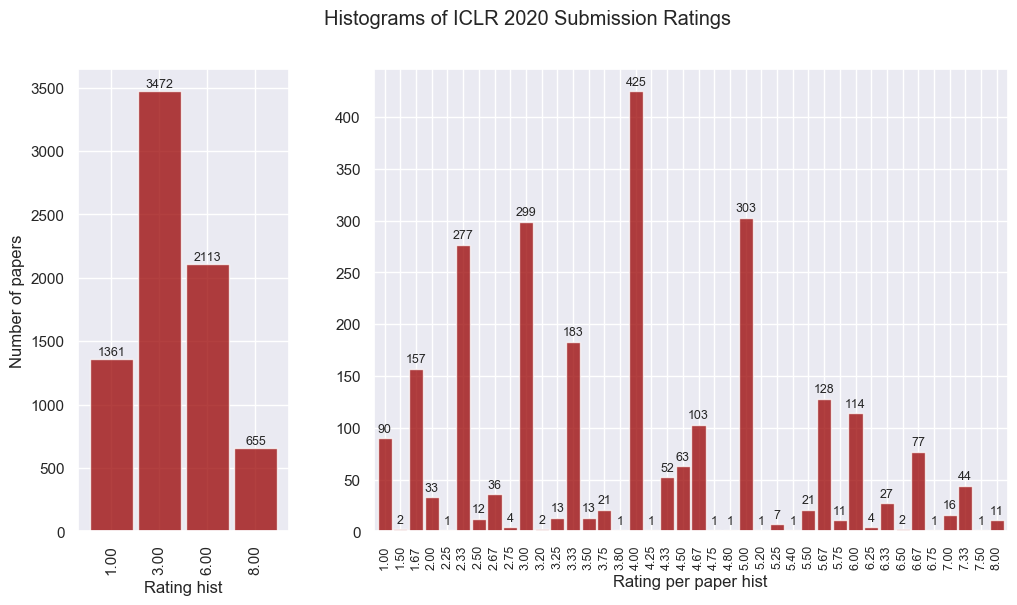

In [23]:
# Plot histograms of ratings
from collections import Counter
from matplotlib import gridspec
import seaborn as sns; sns.set()
fig = plt.figure(figsize=(12, 6))
plt.suptitle('Histograms of ICLR 2020 Submission Ratings')

# Rating hist
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
counterlist =  sorted(Counter(rating).most_common())
frequencies = [k[1] for k in counterlist]
bins = [k[0] for k in counterlist]
freq_series = pd.Series.from_array(frequencies)

x_labels = ['{:.2f}'.format(b) for b in bins]

ax1 = freq_series.plot(kind='bar', color='#990000', alpha=0.75, width=0.9)
ax1.set_xlabel('Rating hist')
ax1.set_ylabel('Number of papers')
ax1.set_xticklabels(x_labels)

rects = ax1.patches
labels = [int(frequencies[i]) for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom', fontsize=9)

# Rating per paper hist
plt.subplot(gs[1])
counterlist =  sorted(Counter(rating_mean).most_common())
frequencies = [k[1] for k in counterlist]
bins = [k[0] for k in counterlist]
freq_series = pd.Series.from_array(frequencies)

x_labels = ['{:.2f}'.format(b) for b in bins]

ax2 = freq_series.plot(kind='bar', color='#990000', alpha=0.75, width=0.9)
ax2.set_xlabel('Rating per paper hist')
ax2.set_xticklabels(x_labels, fontsize=9)

rects = ax2.patches
labels = [int(frequencies[i]) for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width() / 2, height + 3, label,
            ha='center', va='bottom', fontsize=9)
plt.show()

In [39]:
# See how many papers are beaten by yours
def PR(rating_mean, your_rating):
    pr = np.sum(your_rating > np.array(rating_mean))/len(rating_mean)*100
    return pr
my_rating = (6+6+3)/3  # your average rating here
print('Your papar ({:.2f}) beats {:.2f}% of submissions '
      '(well, jsut based on the ratings...)'.format(
          my_rating, PR(rating_mean, my_rating)))

#            accept rate       orals     posters
# ICLR 2017: 39.1% (198/507)    15         183
# ICLR 2018: 32.0% (314/981)    23         291
# ICLR 2019: 31.4% (500/1591)   24         476
# ICLR 2020: ? 

Your papar (5.00) beats 69.95% of submissions (well, jsut based on the ratings...)


In [25]:
# Count keywords
keywords_hist = Counter(keywords)
del keywords_hist['']
print('{} different keywords before merging'.format(len(keywords_hist)))

# Merge duplicates: CNNs and CNN
duplicates = []
for k in keywords_hist:
    if k+'s' in keywords_hist:
        duplicates.append(k)
for k in duplicates:
    keywords_hist[k] += keywords_hist[k+'s']
    del keywords_hist[k+'s']
print('{} different keywords after merging'.format(len(keywords_hist)))

4121 different keywords before merging
3987 different keywords after merging


In [26]:
# Create keywords list
keywords_list = []
keywords_key_list = []
for m in meta_list:
    for k in [mk for mk in m.keyword if not mk == '']:
        if k not in keywords_hist.keys():
            k = k[:-1]  # strip 's'
        if k in keywords_key_list:
            idx = keywords_key_list.index(k)
            keywords_list[idx].update_frequency(1)
            keywords_list[idx].update_rating(m.rating)
        else:
            # the keyword is new to the list
            k_object = Keyword(k, 1, m.rating)
            keywords_list.append(k_object)
            keywords_key_list.append(k_object.keyword)

107


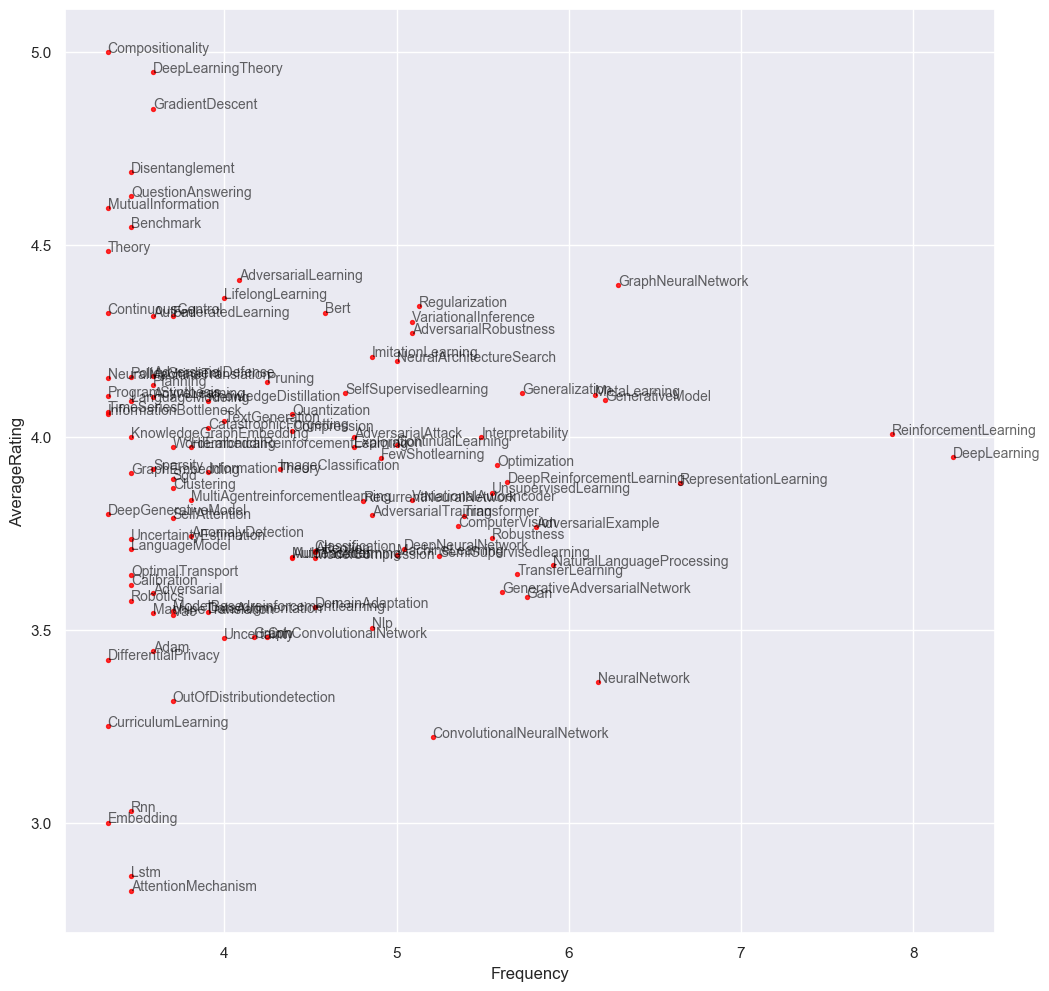

In [27]:
keywords_list_subset = [k for k in keywords_list if k.frequency > 9]
print(len(keywords_list_subset))
y = [k.average_rating() for k in keywords_list_subset]
x = [np.log2(k.frequency) for k in keywords_list_subset]
key = [k.keyword for k in keywords_list_subset]

# Create dataframe
df = pd.DataFrame({
    'Frequency': x,
    'AverageRating': y,
    'Keyword': key
})

sns.set(font_scale=1)
fig = plt.figure(figsize=(12, 12))
p1 = sns.regplot(data=df, x="Frequency", y="AverageRating", fit_reg=False, 
                 marker="o", color="red", logx=True, scatter_kws={'s': 8})
for line in range(0, df.shape[0]):
     p1.text(df.Frequency[line], df.AverageRating[line], df.Keyword[line], 
             horizontalalignment='left', 
             size='small', color='black', alpha=0.6)
plt.show()

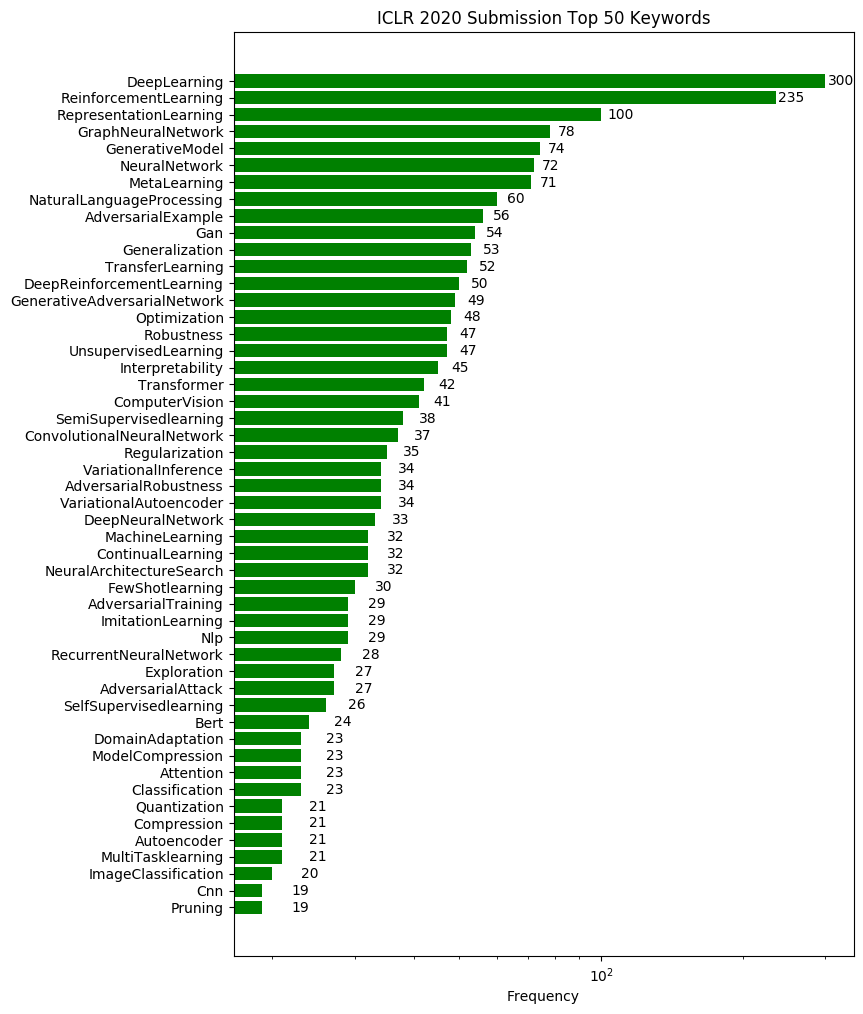

In [28]:
# Show N most common keywords and their frequencies
num_keyowrd = 50
keywords_hist_vis = keywords_hist.most_common(num_keyowrd)

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(8, 12))

key = [k[0] for k in keywords_hist_vis] 
value = [k[1] for k in keywords_hist_vis] 
y_pos = np.arange(len(key))
ax.barh(y_pos, value, align='center', color='green', ecolor='black', log=True)
ax.set_yticks(y_pos)
ax.set_yticklabels(key, rotation=0, fontsize=10)
ax.invert_yaxis() 
for i, v in enumerate(value):
    ax.text(v + 3, i + .25, str(v), color='black', fontsize=10)
# ax.text(y_pos, value, str(value))
ax.set_xlabel('Frequency')
ax.set_title('ICLR 2020 Submission Top {} Keywords'.format(num_keyowrd))

plt.show()

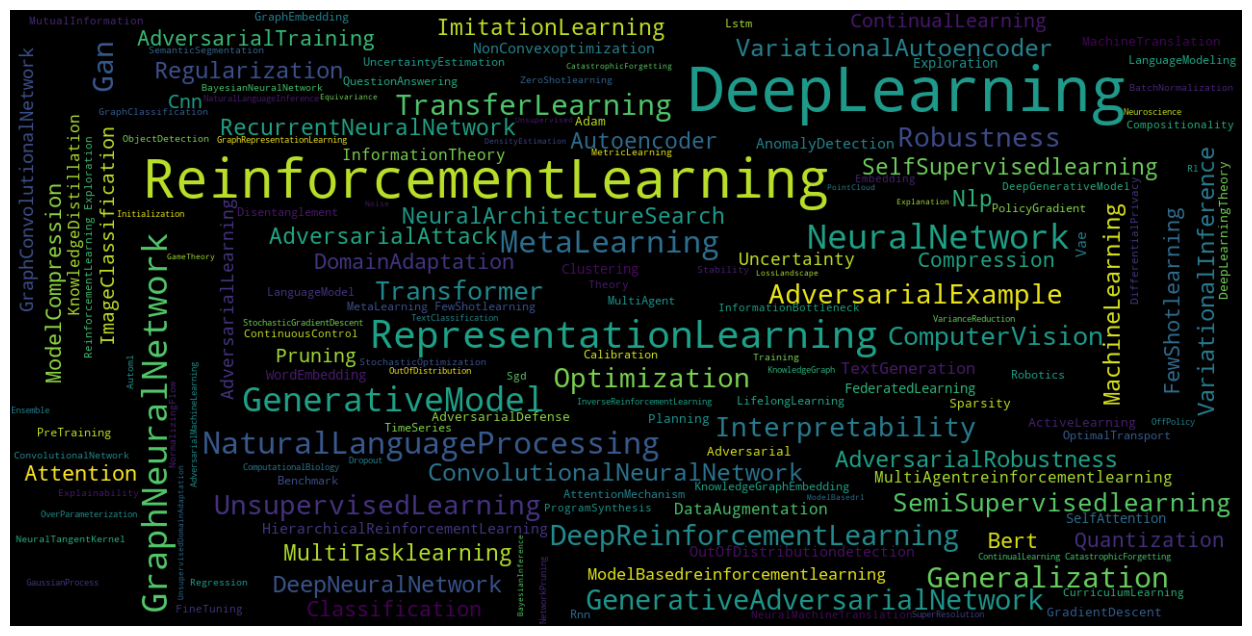

In [29]:
# Show the word cloud forming by keywords
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=64, max_words=160, 
                      width=1280, height=640,
                      background_color="black").generate(' '.join(keywords))
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

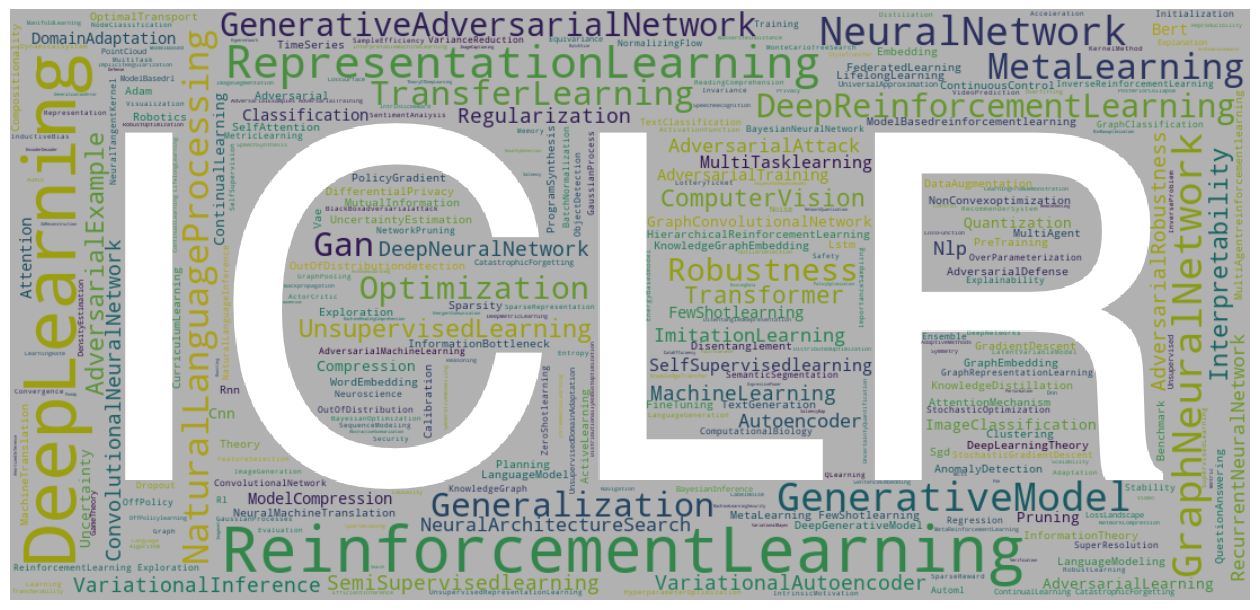

In [30]:
# Show the word cloud with an ICLR logo
from imageio import imread
logo = imread('asset/logo.png')
wordcloud = WordCloud(max_font_size=64, max_words=300, 
                      width=1280, height=640,
                      background_color="white", mask=logo).generate(' '.join(keywords))
plt.figure(figsize=(16, 8), frameon=False)
plt.imshow(logo)
plt.imshow(wordcloud, interpolation="bilinear",  alpha=.7)
plt.axis("off")
plt.show()

In [31]:
num_valid = len(meta_list) - num_withdrawn
num_missing_rating = num_valid*3 - np.sum(np.clip(num_rating, 0, 3))
print('Number of missing reviews: {} ({:.4f}%)'.format(
    num_missing_rating, 100*float(num_missing_rating)/(num_valid*3)))

Number of missing reviews: 256 (3.3294%)


In [32]:
# the papers that don't have 3 reviews
for m in meta_list:
    if len(m.rating) < 3 and not m.withdrawn:
        print(m.title, m.url, m.rating)

Deepobfuscode: Source Code Obfuscation Through Sequence-to-sequence Networks https://openreview.net/forum?id=SygQlT4FwS []
Training Generative Adversarial Networks From Incomplete Observations Using Factorised Discriminators https://openreview.net/forum?id=Hye1RJHKwB [8, 3]
Function Feature Learning Of Neural Networks https://openreview.net/forum?id=rJgCOySYwH [3, 3]
Generative Integration Networks https://openreview.net/forum?id=rkgcsyBKDH []
Bounds On Over-parameterization For Guaranteed Existence Of Descent Paths In Shallow Relu Networks https://openreview.net/forum?id=BkgXHTNtvS [6, 6]
Graphflow: Exploiting Conversation Flow With Graph Neural Networks For Conversational Machine Comprehension https://openreview.net/forum?id=rkgi6JSYvB [1, 1]
Stiffness: A New Perspective On Generalization In Neural Networks https://openreview.net/forum?id=H1e31AEYwB [1, 6]
Relative Pixel Prediction For Autoregressive Image Generation https://openreview.net/forum?id=SyedHyBFwS [3, 3]
Pruned Graph Scat

Muse: Multi-scale Attention Model For Sequence To Sequence Learning https://openreview.net/forum?id=SJe-3REFwr [3, 3]
Towards Modular Algorithm Induction https://openreview.net/forum?id=B1lXfA4Ywr [1, 1]
Multiplicative Interactions And Where To Find Them https://openreview.net/forum?id=rylnK6VtDH [6, 6]
Leveraging Inductive Bias Of Neural Networks For Learning Without Explicit Human Annotations https://openreview.net/forum?id=HJeIX6EKvr [3, 6]
The Divergences Minimized By Non-saturating Gan Training https://openreview.net/forum?id=BygY4grYDr [3, 3]
{companyname}11k: An Unsupervised Representation Learning Dataset For Arrhythmia Subtype Discovery https://openreview.net/forum?id=BkgqL0EtPH [3, 1]
Split Lbi For Deep Learning: Structural Sparsity Via Differential Inclusion Paths https://openreview.net/forum?id=SkxUrTVKDH [6, 8]
Frustratingly Easy Quasi-multitask Learning https://openreview.net/forum?id=H1lXCaVKvS [3, 1]
Regional Based Query In Graph Active Learning https://openreview.net/f

In [33]:
# Write all the data to README
import datetime
with open('README.md', 'r+') as readme:
    lines = readme.readlines()

data_title = '## <a id="Data"></a>All ICLR 2020 OpenReview data\n'
idx = lines.index(data_title)
lines = lines[:idx]

with open('README.md', 'w') as readme:
    for line in lines:
        readme.write(line)
    readme.write(data_title)
    readme.write('Collected at {}\n\n'.format(datetime.datetime.now()))
    readme.write('Number of submissions: {} (withdrawn submissions: {})\n\n'.format(
        len(meta_list), num_withdrawn))
    readme.write('| Rank | Average Rating | Title | Ratings | Variance | Decision |\n')
    readme.write('| --- | --- | --- | --- | --- | --- |\n')
    non_empty_rating_meta_list = [m for m in meta_list if not len(m.rating)==0]
    empty_rating_meta_list = [m for m in meta_list if len(m.rating)==0]    
    sorted_idx = np.argsort([np.mean(m.rating) for m in non_empty_rating_meta_list])[::-1]
    for i, idx in enumerate(sorted_idx):
        m = non_empty_rating_meta_list[idx]
        readme.write('| {} | {:.2f} | [{}]({}) | {} | {:.2f} | {} |\n'.format(
            i+1, np.mean(m.rating), 
            m.title if not m.withdrawn else '~~'+m.title+'~~',  
            m.url, ', '.join([str(r) for r in list(m.rating)]),
            np.std(m.rating), m.decision
        ))
    for i, m in enumerate(empty_rating_meta_list):
        readme.write('| {} | {:.2f} | [{}]({}) | {} | {:.2f} | {} |\n'.format(
            i+1+len(non_empty_rating_meta_list), np.mean(m.rating), 
            m.title if not m.withdrawn else '~~'+m.title+'~~',
            m.url, ', '.join([str(r) for r in list(m.rating)]),
            np.std(m.rating), m.decision
        ))

/Users/waltersun/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/waltersun/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/waltersun/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/waltersun/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/waltersun/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [34]:
# After decision
"""
rating_mean_accept = []
rating_mean_reject = []
for m in meta_list:
    if len(m.rating) > 0:
        if 'Accept' in m.decision:
            rating_mean_accept.append(m.average_rating)
        else:
            rating_mean_reject.append(m.average_rating)
print('Average rating of accepted papers: {}'.format(np.mean(rating_mean_accept)))
print('Average rating of rejected papers: {}'.format(np.mean(rating_mean_reject)))
"""

Average rating of accepted papers: nan
Average rating of rejected papers: 3.9089227562850075


In [36]:
# After decision
"""
fig = plt.figure(figsize=(12, 7))
plt.title('Histograms of ICLR 2020 Submission Ratings', fontsize=15)

# accepted
counterlist_all = sorted(Counter(rating_mean).most_common())
counterlist_accept =  sorted(Counter(rating_mean_accept).most_common())
for c in counterlist_all:
    if c[0] not in [ca[0] for ca in counterlist_accept]:
        counterlist_accept.append((c[0], 0))
counterlist_accept = sorted(counterlist_accept)
frequencies = [k[1] for k in counterlist_accept]
freq_series = pd.Series.from_array(frequencies)
bins = [k[0] for k in counterlist_all]

x_labels = ['{:.2f}'.format(b) for b in bins]

ax1 = freq_series.plot(kind='bar', color='#990000', alpha=0.5, width=0.9)

rects = ax1.patches
labels = [int(frequencies[i]) for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    if label > 0:
        ax1.text(rect.get_x() + rect.get_width() / 2, height + 2, label,
                 ha='center', va='bottom', fontsize=9, color='#990000')

# rejected
counterlist_reject =  sorted(Counter(rating_mean_reject).most_common())
for c in counterlist_all:
    if c[0] not in [ca[0] for ca in counterlist_reject]:
        counterlist_reject.append((c[0], 0))
counterlist_reject = sorted(counterlist_reject)
frequencies = [k[1] for k in counterlist_reject]
freq_series = pd.Series.from_array(frequencies)

ax2 = freq_series.plot(kind='bar', color='#000099', alpha=0.5, width=0.9)
ax2.set_xlabel('Rating per paper hist', fontsize=15)
ax2.set_ylabel('Number of papers', fontsize=15)
ax2.set_xticklabels(x_labels, fontsize=9)

rects = ax2.patches[int(len(rects)/2):]
labels = [int(frequencies[i]) for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    if label > 0:
        ax2.text(rect.get_x() + rect.get_width() / 2, height + 2, label,
                 ha='center', va='bottom', fontsize=9, color='#000099')

ax1.legend(('Accepted Papers', 'Rejected Papers'), fontsize=15)
plt.show()
"""

"\nfig = plt.figure(figsize=(12, 7))\nplt.title('Histograms of ICLR 2020 Submission Ratings', fontsize=15)\n\n# accepted\ncounterlist_all = sorted(Counter(rating_mean).most_common())\ncounterlist_accept =  sorted(Counter(rating_mean_accept).most_common())\nfor c in counterlist_all:\n    if c[0] not in [ca[0] for ca in counterlist_accept]:\n        counterlist_accept.append((c[0], 0))\ncounterlist_accept = sorted(counterlist_accept)\nfrequencies = [k[1] for k in counterlist_accept]\nfreq_series = pd.Series.from_array(frequencies)\nbins = [k[0] for k in counterlist_all]\n\nx_labels = ['{:.2f}'.format(b) for b in bins]\n\nax1 = freq_series.plot(kind='bar', color='#990000', alpha=0.5, width=0.9)\n\nrects = ax1.patches\nlabels = [int(frequencies[i]) for i in range(len(rects))]\n\nfor rect, label in zip(rects, labels):\n    height = rect.get_height()\n    if label > 0:\n        ax1.text(rect.get_x() + rect.get_width() / 2, height + 2, label,\n                 ha='center', va='bottom', fontsi